<a href="https://colab.research.google.com/github/Swayamprakashpatel/Sol_ME/blob/main/Sol_ME.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
import io
#df = pd.read_csv('/content/drive/My Drive/DE.csv', low_memory=False,)
url = '/content/Data_FP.csv'
df = pd.read_csv(url, low_memory=False,) # Run for labeled data
 
#df.fillna('&',inplace=True)
df.drop('DRUG', axis = 1, inplace = True)
df.drop('CARRIER', axis = 1, inplace = True)
print(df.shape)
df.head()
df.dtypes
df.columns[df.isna().any()].tolist()
dataset = df.values


(408, 1763)


In [5]:
X = dataset[:,0:1762]
#Y = dataset[:,1762:1763]
# Run this for labeled data
Y = dataset[:,1762:1763]
#Y = np.log(Y) 
#print(X, X.shape,X.dtype)
#print(Y, Y.shape, Y.dtype)
 

In [9]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X, Y, test_size=0.1,random_state = 10 )
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5, random_state= 10)
import numpy as np
 
X_train = np.asarray(X_train).astype(np.int64)
X_val = np.asarray(X_val).astype(np.int64)
X_test = np.asarray(X_test).astype(np.int64)
Y_train = np.asarray(Y_train).astype(np.int64)
Y_val = np.asarray(Y_val).astype(np.int64)
Y_test = np.asarray(Y_test).astype(np.int64)
 
filepath = '/content/drive/My Drive/SOLModel.hdf5'
 
checkpoint = [tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_root_mean_squared_error', mode='min', save_best_only=True, Save_weights_only = False, verbose = 1), 
              tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', patience=75, verbose =1)]
output_nodes = Y.shape[1]
print(output_nodes)


1


Epoch 1/2000
11/12 [==========================>...] - ETA: 0s - loss: 7518.5732 - root_mean_squared_error: 86.7097
Epoch 1: val_root_mean_squared_error improved from inf to 37.30852, saving model to /content/drive/My Drive/SOLModel.hdf5
12/12 [==============================] - 1s 30ms/step - loss: 7618.6660 - root_mean_squared_error: 87.2850 - val_loss: 1391.9254 - val_root_mean_squared_error: 37.3085
Epoch 2/2000
10/12 [========================>.....] - ETA: 0s - loss: 6484.5635 - root_mean_squared_error: 80.5268
Epoch 2: val_root_mean_squared_error improved from 37.30852 to 36.72600, saving model to /content/drive/My Drive/SOLModel.hdf5
12/12 [==============================] - 0s 20ms/step - loss: 6745.9517 - root_mean_squared_error: 82.1337 - val_loss: 1348.7991 - val_root_mean_squared_error: 36.7260
Epoch 3/2000
11/12 [==========================>...] - ETA: 0s - loss: 5909.1943 - root_mean_squared_error: 76.8713
Epoch 3: val_root_mean_squared_error improved from 36.72600 to 35.2139

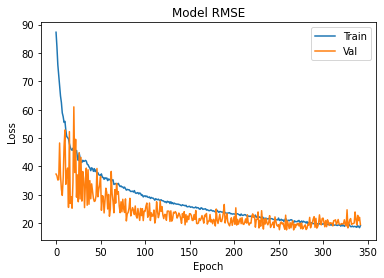

Training RMSE is
18.402252197265625
Validation RMSE is
17.6229248046875
Training loss is
338.6428527832031
Validation loss is
310.5675048828125


In [10]:
model = tf.keras.Sequential([
                             tf.keras.layers.Dense(512, activation='relu', input_shape=(1762,)),
                             tf.keras.layers.Dense(512, activation='relu'),
                             #tf.keras.layers.Dense(1762, activation='relu'),
                             tf.keras.layers.Dense(output_nodes, activation ='linear')])

model.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate = 0.1), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.RootMeanSquaredError()])
hist = model.fit(X_train, Y_train, epochs= 2000, callbacks=[checkpoint],validation_data=(X_val, Y_val), batch_size= None)
model.evaluate(X_test, Y_test)
 
# Error Graph

plt.plot(hist.history['root_mean_squared_error'])
plt.plot(hist.history['val_root_mean_squared_error'])
plt.title('Model RMSE')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()
 

train_acc = min(hist.history['root_mean_squared_error'])
val_acc = min(hist.history['val_root_mean_squared_error'])
train_loss = min(hist.history['loss'])
val_loss = min(hist.history['val_loss'])
print('Training RMSE is')
print(train_acc)
print('Validation RMSE is')
print(val_acc)
print('Training loss is')
print(train_loss)
print('Validation loss is')
print(val_loss)

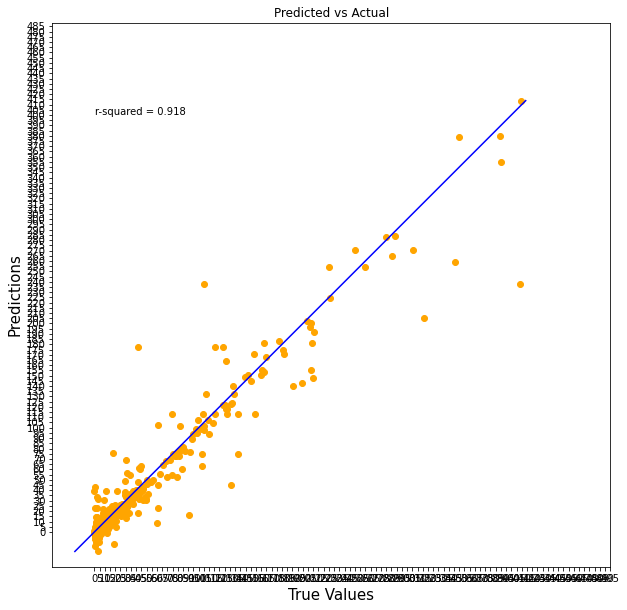

In [11]:
from sklearn.metrics import r2_score
true_value = Y
predicted_value = model.predict(X)

plt.figure(figsize=(10,10))
plt.scatter(true_value, predicted_value, c='orange')
plt.yscale('linear')
plt.xscale('linear')

p1 = max(max(predicted_value), max(true_value))
p2 = min(min(predicted_value), min(true_value))
plt.plot([p1, p2], [p1, p2], 'blue')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.title('Predicted vs Actual')
plt.annotate("r-squared = {:.3f}".format(r2_score(true_value, predicted_value)), (1,400), )
plt.xticks( range(0,500,5) )
plt.yticks( range(0,500,5) )
plt.show()

In [12]:
#@title Insert PubChem Fingerprint of Drug and Carrier (Oil, Surfactant, Cosurfactant)
!pip install pubchempy
import tensorflow as tf
import pandas as pd 
import numpy as np 
import io
from tensorflow import keras
import pubchempy as pcp
from sklearn.preprocessing import OneHotEncoder
from keras.models import load_model
import time as tm
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1jN7P3FFzekgqeEXPsL8p-pTxB_fdOmFh',
                                    dest_path='/content/sample_data/Sol_ME.hdf5',
                                    unzip=False)
#Load Model
model = load_model('/content/sample_data/Sol_ME.hdf5', compile= True)


Drug_CID =  3672#@param {type:"number"}
Excipient_CID =  5284448#@param {type:"number"}


CID_D = pcp.Compound.from_cid(Drug_CID)
CID_E = pcp.Compound.from_cid(Excipient_CID)

FPD = CID_D.cactvs_fingerprint
FPE = CID_E.cactvs_fingerprint
List1 = list(FPD)
List2 = list(FPE)
List = List1 + List2
 
import pandas as pd
t = pd.DataFrame(np.array(List).reshape(-1,len(List)))
 
#@title RUN FOR PREDICTION
 
 
dataset1 = t.values
t.dtype = int
X_Predict = (dataset1[:,0:1762].astype(int))
print(X_Predict)
print(X_Predict.shape)
print(X_Predict.dtype)
 
Y_prediction = model.predict(X_Predict)
 
print(Y_prediction, "mg/ml")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[[1 1 1 ... 0 0 0]]
(1, 1762)
int64
[[258.82654]] mg/ml
